In [70]:
#Packages to use
import scanpy as sc
import seaborn as sns
import numpy as np
import anndata as ad
import scvi
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import biomart

#Directory to work out of
directory = '/Users/david/Dropbox/RNASeq/POA'

In [2]:
#Get list of ribosomal genes
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=WP_CYTOPLASMIC_RIBOSOMAL_PROTEINS&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

In [42]:
#pre-processing function for each batch
def preprocess(matrix_path,name):
    adata = sc.read_10x_mtx(matrix_path)
    adata.obs['Sample'] = name
    sc.pp.filter_cells(adata, min_counts = 1000)
    sc.pp.filter_cells(adata, max_counts = 40000)
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.str.lower().isin(ribo_genes[0].str.lower())
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < 20] #these values are unusually high in this dataset
    adata = adata[adata.obs.pct_counts_ribo < 30] #these values are unusually high in this dataset
    adata.obs.index=adata.obs['Sample'].to_numpy() + ":" + np.array(adata.obs.index)
    return adata

In [43]:
#perform pre-processing
names = ['AM','AF','OV','CA']
files = ['AM','AF','OV','CA']
out = []
for x in range(0,len(names)):
    out.append(preprocess(directory + '/Matrices/' + files[x],names[x]))

In [44]:
#combine all batches
adata = sc.concat(out)
sc.pp.filter_genes(adata, min_cells = 1) #get rid of genes with no counts
adata.X.shape

(22829, 21035)

In [45]:
#convert to sparse matrix
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)

In [46]:
adata.layers['counts'] = adata.X.copy() #save a raw counts version

In [47]:
directory = '/Users/david/Dropbox/RNASeq/MPOA2'

In [49]:
adata.write_h5ad(directory + '/combined.h5ad')

In [50]:
adata = sc.read_h5ad(directory + '/combined.h5ad')
adata.obs.index

Index(['AM:AAACCTGAGATCGATA-1', 'AM:AAACCTGAGATGGGTC-1',
       'AM:AAACCTGAGGAGCGTT-1', 'AM:AAACCTGCAAGGGTCA-1',
       'AM:AAACCTGCATACGCTA-1', 'AM:AAACCTGCATCACAAC-1',
       'AM:AAACCTGCATGTCGAT-1', 'AM:AAACCTGCATTAGGCT-1',
       'AM:AAACCTGCATTGTGCA-1', 'AM:AAACCTGTCAGCCTAA-1',
       ...
       'CA:TTTGTCACATGGAATA-1', 'CA:TTTGTCACATTACCTT-1',
       'CA:TTTGTCAGTACAGCAG-1', 'CA:TTTGTCAGTATGAAAC-1',
       'CA:TTTGTCAGTCCGAATT-1', 'CA:TTTGTCAGTTATCACG-1',
       'CA:TTTGTCATCAGTACGT-1', 'CA:TTTGTCATCCCTAATT-1',
       'CA:TTTGTCATCCCTTGTG-1', 'CA:TTTGTCATCGGCGCTA-1'],
      dtype='object', length=22829)

In [51]:
#get highly variable genes for gene expression similarity analysis
sc.pp.filter_genes(adata, min_cells = 10) #filter once concatenated across sessions
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, layer='counts', flavor = 'seurat_v3', batch_key='Sample')
adata.X.shape

(22829, 2000)

In [52]:
#setup scVI model
scvi.model.SCVI.setup_anndata(adata, layer = 'counts',
                             batch_key='Sample')
model = scvi.model.SCVI(adata)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [53]:
#train model
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/350:   0%|                                      | 0/350 [00:00<?, ?it/s]

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 350/350: 100%|█| 350/350 [16:51<00:00,  2.43s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=350` reached.


Epoch 350/350: 100%|█| 350/350 [16:51<00:00,  2.89s/it, v_num=1, train_loss_step


In [54]:
#save latent variables
adata.obsm['X_scVI'] = model.get_latent_representation()

In [55]:
#doublet detection function
def doubdetect(name):
    solo_batch = scvi.external.SOLO.from_scvi_model(model, restrict_to_batch=name)
    solo_batch.train()
    bp = solo_batch.predict()
    return bp

In [56]:
#perform doublet detection
names = ['AM','AF','OV','CA']
out = []
for x in range(0,4):
    out.append(doubdetect(names[x]))

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 196/400:  49%|▍| 196/400 [00:49<00:51,  3.95it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.203. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 330/400:  82%|▊| 330/400 [01:21<00:17,  4.04it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.155. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 355/400:  89%|▉| 355/400 [01:38<00:12,  3.61it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.196. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 156/400:  39%|▍| 156/400 [00:33<00:52,  4.68it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.191. Signaling Trainer to stop.


In [57]:
#identify doublet barcodes
dps = pd.concat(out,axis=0)
dps['isdoublet']=dps['doublet']>dps['singlet']

In [ ]:
#remove doublets
adata=adata[dps['isdoublet']==False]
adata.X.shape

In [59]:
adata.write_h5ad(directory + '/integrated.h5ad')

In [90]:
adata = sc.read_h5ad(directory + '/combined.h5ad')
adata_scvi = sc.read_h5ad(directory + '/integrated.h5ad')

In [61]:
#remove doublets and save latent variables to original matrix (with all genes)
barcodes_inc = adata_scvi.obs.index
adata = adata[adata.obs.index.isin(barcodes_inc)]
adata.obsm['X_scVI'] = adata_scvi.obsm['X_scVI']

/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_95597/1981361815.py:4: ImplicitModificationWarning: Setting element `.obsm['X_scVI']` of view, initializing view as actual.
  adata.obsm['X_scVI'] = adata_scvi.obsm['X_scVI']


In [72]:
adata.X.shape

(20170, 21035)

In [63]:
#calculate nearest neighbors
sc.pp.neighbors(adata, use_rep = 'X_scVI', n_neighbors=50)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


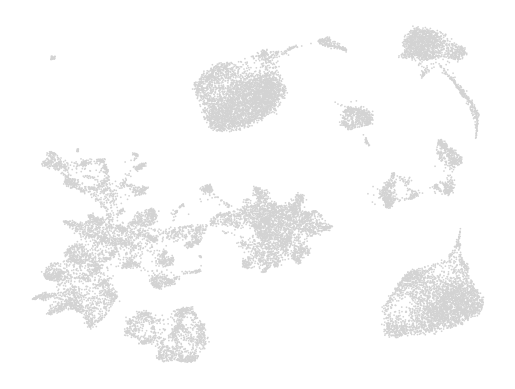

In [91]:
#calculate UMAP
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, frameon = False)

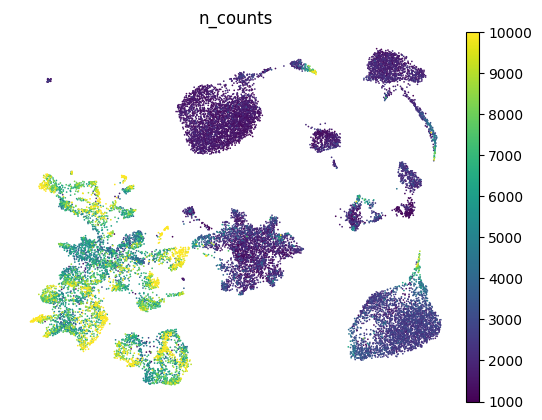

In [92]:
sc.pl.umap(adata, color = ['n_counts'], frameon = False, vmax = 10000)

In [66]:
#cluster for cell-typing
sc.tl.leiden(adata, resolution = 0.07)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


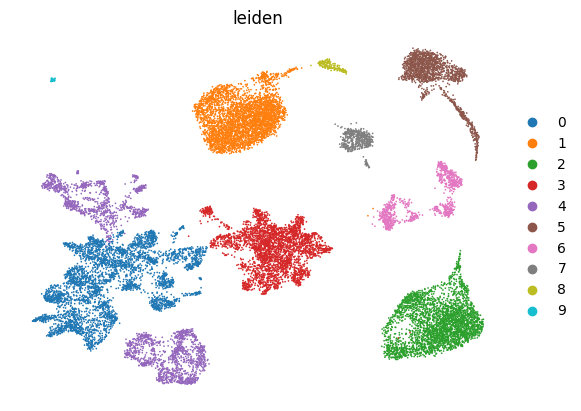

In [93]:
sc.pl.umap(adata, color = ['leiden'], frameon = False)

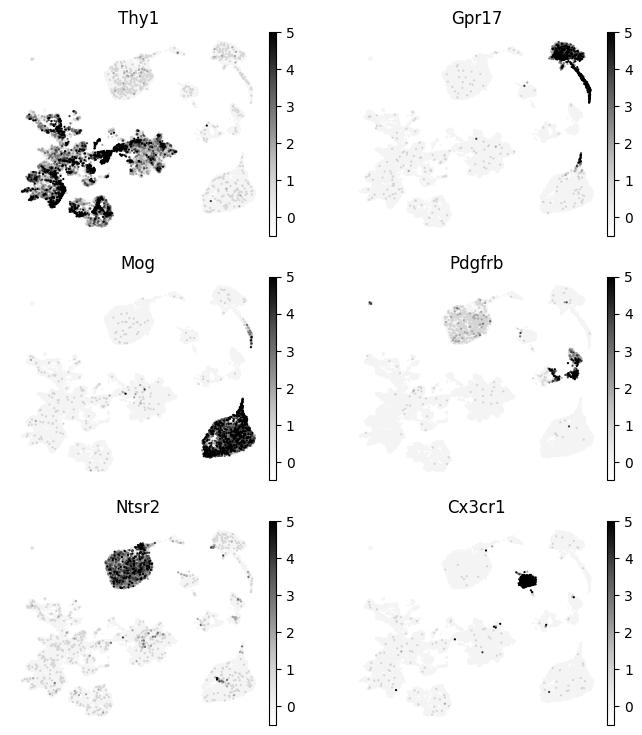

In [73]:
plt.figure(figsize = (8,9))
um = plt.subplot(3,2,1)
um = sc.pl.umap(adata, color = ['Thy1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,2)
um = sc.pl.umap(adata, color = ['Gpr17'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,3)
um = sc.pl.umap(adata, color = ['Mog'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,4)
um = sc.pl.umap(adata, color = ['Pdgfrb'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,5)
um = sc.pl.umap(adata, color = ['Ntsr2'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,6)
um = sc.pl.umap(adata, color = ['Cx3cr1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
#plt.savefig(directory + '/Figures/cellsExpression.png')

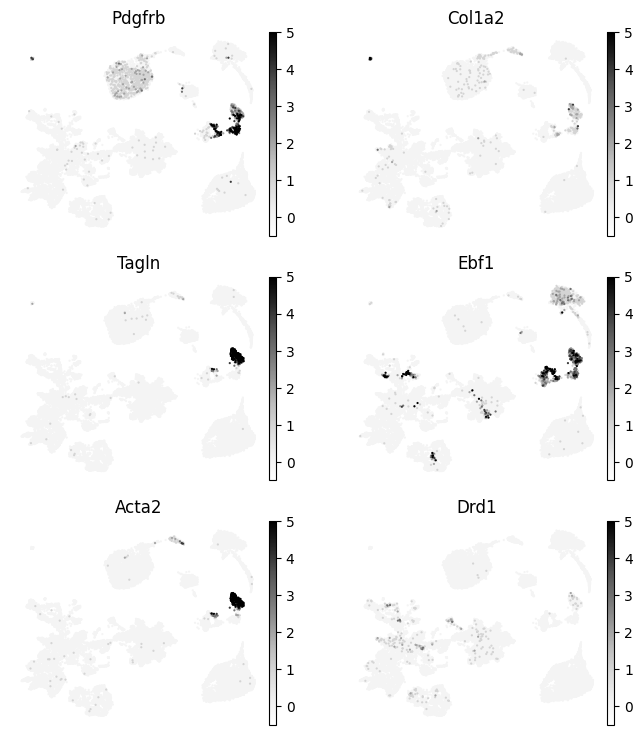

In [74]:
plt.figure(figsize = (8,9))
um = plt.subplot(3,2,1)
um = sc.pl.umap(adata, color = ['Pdgfrb'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,2)
um = sc.pl.umap(adata, color = ['Col1a2'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,3)
um = sc.pl.umap(adata, color = ['Tagln'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,4)
um = sc.pl.umap(adata, color = ['Ebf1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,5)
um = sc.pl.umap(adata, color = ['Acta2'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,6)
um = sc.pl.umap(adata, color = ['Drd1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)

In [21]:
#map clusters into cell types
cell_type = {"0":"Neurons",
             "3":"Neurons",
             "2":"Oligodendrocytes",
             "4":"Neurons",
"1":"Astrocytes",
"6":"Fibr./Murine/Endothel.",
"7":"Microglia",
"5":"Oligo. precursor cells",
"8":"Astrocytes",
"9":"Fibr./Murine/Endothel.",
}

adata.obs['celltype'] = adata.obs.leiden.map(cell_type)

In [76]:
ctcolors = {"Neurons":(0.71, 0.88, 0.54),
            "Oligodendrocytes":(0.86, 0.52, 0.83),
            "Astrocytes":(0.58, 0.73, 0.94),
            "Oligo. precursor cells":(0.97, 0.62, 0.62),
            "Microglia":(0.97, 0.8, 0.55),
            "Fibr./Murine/Endothel.":(0.97, 0.93, 0.68),
           }

In [19]:
plt.rcParams['figure.dpi'] = 300

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


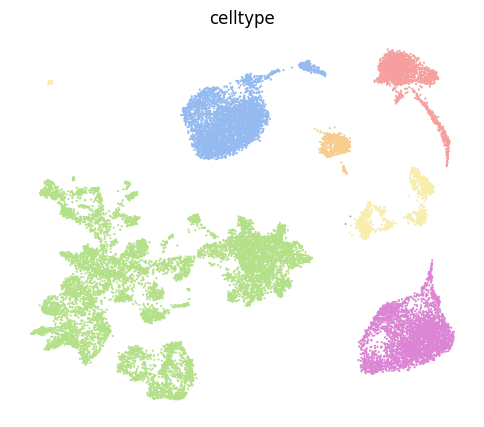

In [77]:
plt.figure(figsize = (6,5))
um = plt.subplot(1,1,1)
um = sc.pl.umap(adata, color = ['celltype'], frameon = False, size=10, ax = um, palette = ctcolors, show=False, legend_loc='off right')
plt.savefig(directory + '/Figures/cellsUMAP.png')

In [79]:
ctcolorsN = {"Neurons":(0.71, 0.88, 0.54),
            "Oligodendrocytes":(0.8, 0.8, 0.8),
            "Astrocytes":(0.8, 0.8, 0.8),
            "Oligo. precursor cells":(0.8, 0.8, 0.8),
            "Microglia":(0.8, 0.8, 0.8),
            "Fibr./Murine/Endothel.":(0.8, 0.8, 0.8),
           }

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


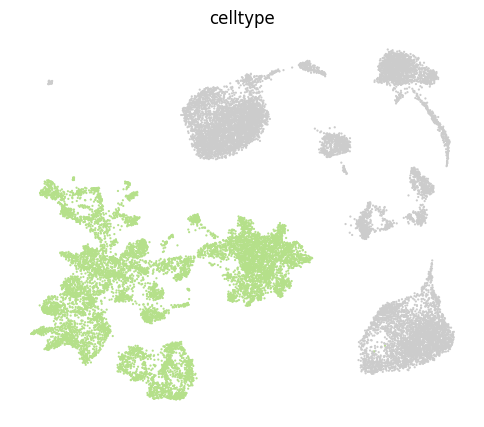

In [80]:
plt.figure(figsize = (6,5))
um = plt.subplot(1,1,1)
um = sc.pl.umap(adata, color = ['celltype'], frameon = False, size=10, ax = um, palette = ctcolorsN, show=False, legend_loc='off right')
plt.savefig(directory + '/Figures/cellsUMAPN.png')

In [81]:
gpcolors = {"AM":np.divide((106, 106, 106),256),
            "AF":np.divide((175, 175, 175),256),
            "OV":np.divide((148, 35, 236),256),
            "CA":np.divide((208, 158, 247),256),
           }

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


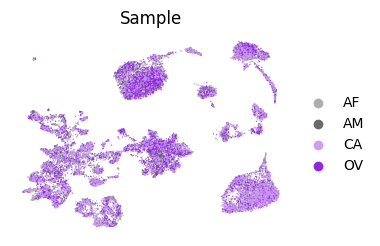

In [82]:
#color by batch
kwargs = {'alpha': 0.75}
plt.figure(figsize = (8,9))
um = plt.subplot(3,2,1)
um = sc.pl.umap(adata, color = ['Sample'], frameon = False,
                size=4, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                show=False, palette = gpcolors, **kwargs)
plt.savefig(directory + '/Figures/cellsGroupUMAP.png')

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-pack

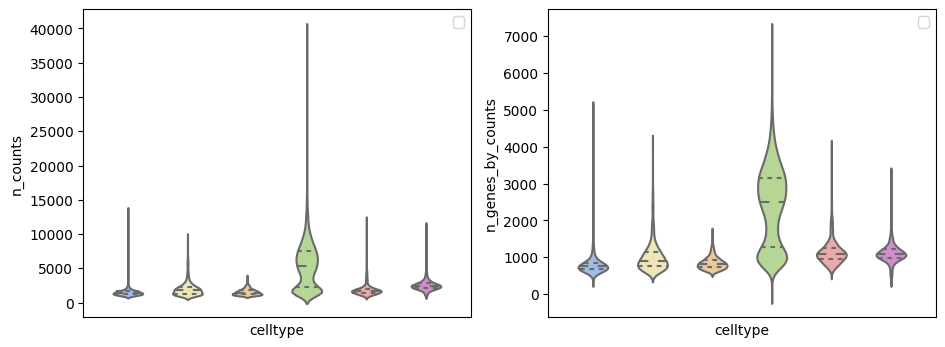

In [83]:
#quality metrics
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
sns.violinplot(adata.obs,x='celltype',y='n_counts',hue='celltype',split=False,inner='quart',palette=ctcolors, width=6)
plt.xlim((-4,9))
plt.xticks(())
plt.legend(())

plt.subplot(1,2,2)
sns.violinplot(adata.obs,x='celltype',y='n_genes_by_counts',hue='celltype',split=False,inner='quart',palette=ctcolors, width=6)
plt.xlim((-4,9))
plt.xticks(())
plt.legend(())
plt.savefig(directory + '/Figures/cellsQM.svg')

In [143]:
adata.obs

,Sample,n_counts,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden,celltype
BF:AATTTCCCGTCA,BF,18130.0,5138,18130.0,953.0,5.256481,325.0,1.792609,0,Neurons
BF:TTGTTGCGTCCT,BF,17885.0,5113,17885.0,1012.0,5.658373,258.0,1.442550,0,Neurons
BF:AACGCGGTTCAC,BF,17996.0,4988,17996.0,891.0,4.951100,273.0,1.517004,0,Neurons
BF:CTTGAGAGCGCC,BF,15669.0,4781,15669.0,1218.0,7.773311,179.0,1.142383,0,Neurons
BF:TACACCCTCTCC,BF,17785.0,5129,17785.0,1141.0,6.415518,222.0,1.248243,0,Neurons
...,...,...,...,...,...,...,...,...,...,...
BI:ATCTGTGTCCCT,BI,1136.0,861,1136.0,21.0,1.848591,10.0,0.880282,0,Neurons
BI:GTGCCCTGATGC,BI,1006.0,602,1006.0,22.0,2.186879,8.0,0.795229,1,Oligodendrocytes
BI:TGTAACGTGTGA,BI,1090.0,868,1090.0,19.0,1.743119,8.0,0.733945,0,Neurons
BI:CCCACGCCACCA,BI,1017.0,805,1017.0,19.0,1.868240,19.0,1.868240,0,Neurons


In [30]:
adata.write_h5ad(directory + '/combined.h5ad')

In [31]:
adata = adata[adata.obs.celltype=='Neurons']
adata.X.shape

(9807, 21035)

In [ ]:
#prepare for Map My Cell

In [33]:
#function to create mappings for translating NCBI gene into Ensembl gene
def get_ensembl_mappings():                                   
    # Set up connection to server                                               
    server = biomart.BiomartServer('http://useast.ensembl.org/biomart')         
    mart = server.datasets['mmusculus_gene_ensembl']                            
                                                                                
    # List the types of data we want                                            
    attributes = ['mgi_symbol','ensembl_gene_id']
                                                                                
    # Get the mapping between the attributes                                    
    response = mart.search({'attributes': attributes})                          
    data = response.raw.data.decode('ascii')                                    
                                                                                
    ensembl_to_genesymbol = {}                                                  
    # Store the data in a dict                                                  
    for line in data.splitlines():                                              
        line = line.split('\t')                                                 
        gene_symbol = line[0]                                                   
        ensembl_gene = line[1]                                                  
        ensembl_to_genesymbol[gene_symbol] = ensembl_gene                      
                                                                                
    return ensembl_to_genesymbol

In [34]:
mappings = get_ensembl_mappings()

In [35]:
#get Ensembl names
varlist = adata.var.index.to_numpy()
varlistens = varlist.copy()
include = np.full(len(varlist),False)
gdb = list(mappings.keys())
for x in range(0,len(varlist)):
    if np.isin(varlist[x],gdb):
        varlistens[x]=mappings[varlist[x]]
        include[x]=True

In [36]:
#create smaller anndata with just ens gene and barcodes
adataS = ad.AnnData(adata[:,include].layers['counts'])
adataS.var.index=varlistens[include]
adataS.obs.index=adata.obs.index

In [37]:
adataS.write_h5ad(directory + '/neuronsMMC.h5ad')

In [38]:
#load in results from MMC
mmcdata = pd.read_csv(directory + '/mmc.csv', header=4, index_col=0)

In [39]:
adata.obs['class']=mmcdata['class_name'].astype('category')
adata.obs['subclass']=mmcdata['subclass_name'].astype('category')
adata.obs['supertype']=mmcdata['supertype_name'].astype('category')
adata.obs['cluster']=mmcdata['cluster_name'].astype('category')

/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_68250/967811297.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['class']=mmcdata['class_name'].astype('category')


In [40]:
adata.obs

,Sample,n_counts,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden,celltype,class,subclass,supertype,cluster
AM:AAACCTGAGATCGATA-1,AM,7002.0,2751,7002.0,330.0,4.712939,1966.0,28.077692,0,Neurons,12 HY GABA,106 PVpo-VMPO-MPN Hmx2 Gaba,0482 PVpo-VMPO-MPN Hmx2 Gaba_1,1877 PVpo-VMPO-MPN Hmx2 Gaba_1
AM:AAACCTGAGATGGGTC-1,AM,5187.0,2572,5187.0,352.0,6.786196,637.0,12.280702,0,Neurons,11 CNU-HYa GABA,089 PVR Six3 Sox3 Gaba,0414 PVR Six3 Sox3 Gaba_4,1515 PVR Six3 Sox3 Gaba_4
AM:AAACCTGCATGTCGAT-1,AM,1675.0,1015,1675.0,180.0,10.746269,86.0,5.134328,3,Neurons,11 CNU-HYa GABA,086 MPO-ADP Lhx8 Gaba,0404 MPO-ADP Lhx8 Gaba_3,1470 MPO-ADP Lhx8 Gaba_3
AM:AAACCTGCATTGTGCA-1,AM,6235.0,2895,6235.0,294.0,4.715317,749.0,12.012831,4,Neurons,13 CNU-HYa Glut,118 ADP-MPO Trp73 Glut,0527 ADP-MPO Trp73 Glut_1,2119 ADP-MPO Trp73 Glut_1
AM:AAACGGGAGGGTCTCC-1,AM,8350.0,3254,8350.0,525.0,6.287425,1593.0,19.077845,0,Neurons,12 HY GABA,106 PVpo-VMPO-MPN Hmx2 Gaba,0485 PVpo-VMPO-MPN Hmx2 Gaba_4,1911 PVpo-VMPO-MPN Hmx2 Gaba_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CA:TTTGTCAAGGCTACGA-1,CA,6499.0,2712,6499.0,197.0,3.031235,1648.0,25.357746,0,Neurons,12 HY GABA,106 PVpo-VMPO-MPN Hmx2 Gaba,0483 PVpo-VMPO-MPN Hmx2 Gaba_2,1888 PVpo-VMPO-MPN Hmx2 Gaba_2
CA:TTTGTCAAGTACTTGC-1,CA,1827.0,1146,1827.0,231.0,12.643679,98.0,5.363985,3,Neurons,11 CNU-HYa GABA,088 BST Tac2 Gaba,0409 BST Tac2 Gaba_1,1498 BST Tac2 Gaba_1
CA:TTTGTCACAAGCCTAT-1,CA,6317.0,2722,6317.0,308.0,4.875732,1152.0,18.236504,4,Neurons,14 HY Glut,124 MPN-MPO-PVpo Hmx2 Glut,0551 MPN-MPO-PVpo Hmx2 Glut_6,2260 MPN-MPO-PVpo Hmx2 Glut_6
CA:TTTGTCACATTACCTT-1,CA,1611.0,968,1611.0,249.0,15.456239,63.0,3.910614,3,Neurons,11 CNU-HYa GABA,086 MPO-ADP Lhx8 Gaba,0406 MPO-ADP Lhx8 Gaba_5,1482 MPO-ADP Lhx8 Gaba_5


In [41]:
del(adata.obsm,adata.obsp,adata.uns,adata.obs['n_counts'],adata.obs['leiden'],adata.obs['celltype'],adata.var)

In [42]:
adata.write_h5ad(directory + '/neurons.h5ad')

In [87]:
#get color palettes
#Allen metadata file: https://allen-brain-cell-atlas.s3.us-west-2.amazonaws.com/index.html#metadata/WMB-10X/20231215/views/
allMeta = pd.read_csv('/Users/david/Dropbox/RNASeq/AllenPAL/Data/cell_metadata_with_cluster_annotation.csv')

(classes,ci) = np.unique(allMeta['class'].to_numpy(),return_index=True)
cc = allMeta['class_color'].to_numpy()[ci]
classp = dict(zip(classes,cc))
classp['None']=(0.8,0.8,0.8,0.2)

(subclasses,si) = np.unique(allMeta['subclass'].to_numpy(),return_index=True)
scc = allMeta['subclass_color'].to_numpy()[si]
subclassp = dict(zip(subclasses,scc))
subclassp['None']=(0.8,0.8,0.8,0.2)

ntlist=allMeta['neurotransmitter'][allMeta['neurotransmitter']==allMeta['neurotransmitter']].to_numpy()
ntclist=allMeta['neurotransmitter_color'][allMeta['neurotransmitter']==allMeta['neurotransmitter']].to_numpy()
(neurotransmitters,ni) = np.unique(ntlist,return_index=True)
nc = ntclist[ni]
neurotransmitterp = dict(zip(neurotransmitters,nc))
neurotransmitterp['None']=(0.8,0.8,0.8,0.2)

del(allMeta)

/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_95597/3778227727.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  allMeta = pd.read_csv('/Users/david/Dropbox/RNASeq/AllenPAL/Data/cell_metadata_with_cluster_annotation.csv')


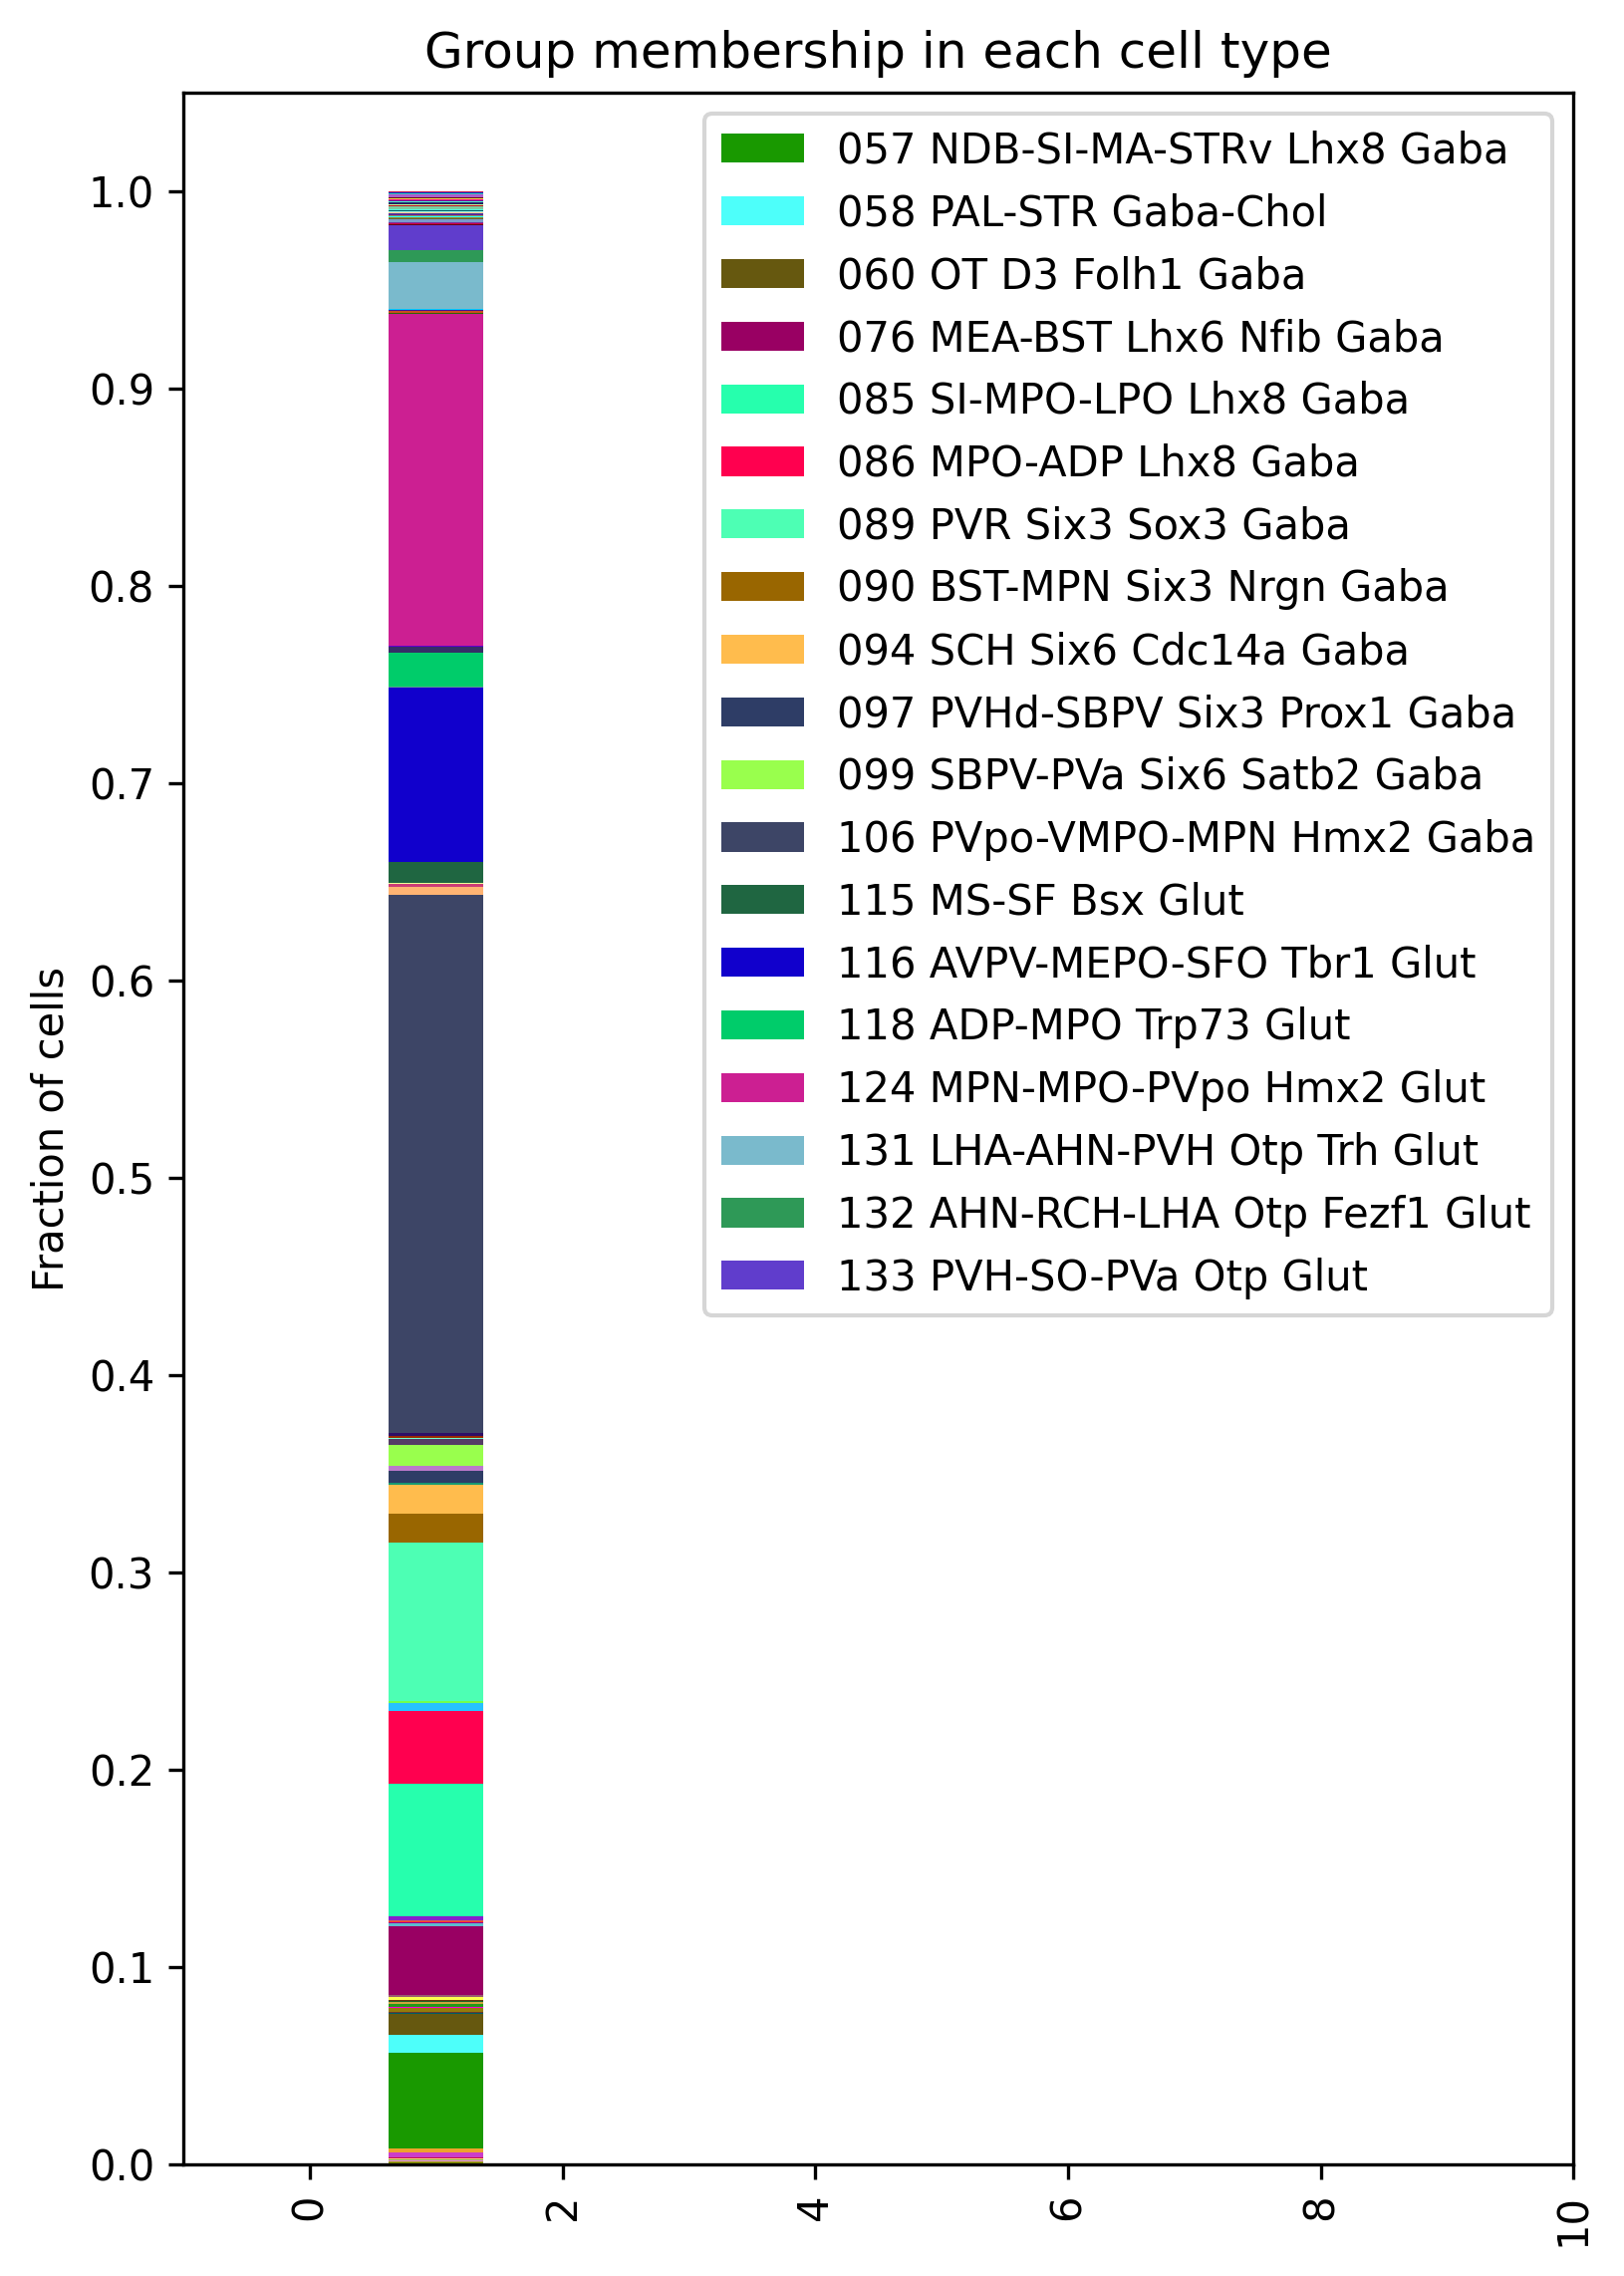

In [44]:
#plot the proportion of neurons in each subclass
order = [1]
groupnames = np.unique(adata.obs['subclass'])
typecount=np.zeros((len(groupnames),len(order)))
for g in range(0,len(groupnames)):   
    for t in range(0,len(order)):
        typecount[g,t]=np.sum((adata.obs['subclass']==groupnames[g]))                   

tcn = np.divide(typecount,np.sum(typecount,axis=0))

width = 0.75

fig, ax = plt.subplots(figsize = (6,9))
bottom = np.zeros(len(order))

lhs=[]
inc=np.full((len(groupnames),1),False,dtype='bool')
inccolors=[]
for g in range(0,len(groupnames)):
    p = ax.bar(order, tcn[g,:], width, label=groupnames[g], bottom=bottom, color=subclassp[groupnames[g]])
    bottom += tcn[g,:]
    if np.max(tcn[g,0:5])>=0.005:
        lhs.append(p)
        inc[g]=True
        inccolors.append(subclassp[groupnames[g]])
inc=inc.squeeze()

ax.legend(handles=lhs,loc="upper right", ncols=1)

plt.title('Group membership in each cell type')
plt.xlim((-1,10))
plt.xticks(rotation=90)
plt.yticks(np.arange(0,1.1,0.1))
plt.ylabel('Fraction of cells')
plt.savefig(directory + '/Figures/propSubclass.svg')

In [84]:
adata = sc.read_h5ad(directory + '/combined.h5ad')
adata_neuron = sc.read_h5ad(directory + '/neurons.h5ad')

In [85]:
adata.obs['subclass']=adata_neuron.obs['subclass']

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


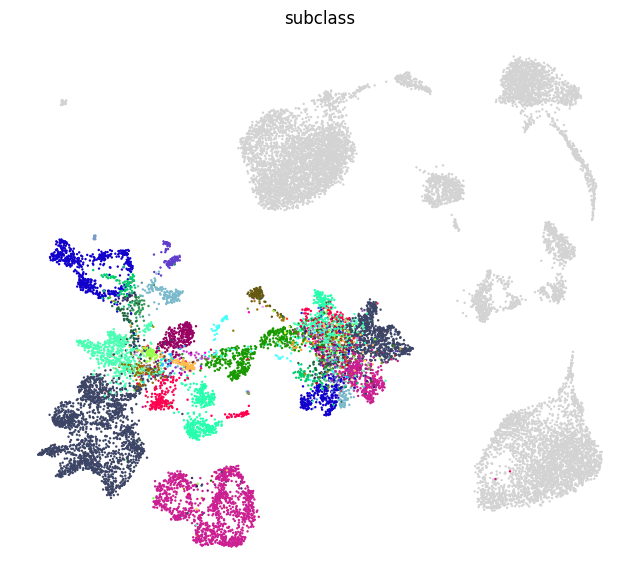

In [89]:
#plot subclass for neurons
subclasses = np.unique(adata.obs['subclass'][adata.obs['subclass']==adata.obs['subclass']])
groups = subclasses[subclasses!='None']

plt.figure(figsize=(8,7))
ax=plt.subplot(1,1,1)
#sc.pl.umap(adata, color = ['Experiment'], size = 4, frameon = False, palette=excolors)
sc.pl.umap(adata, color = ['subclass'], groups = groups.tolist(), size = 12, frameon = False, palette=subclassp, ax=ax, show=False, legend_loc='off')
plt.savefig(directory + '/Figures/POASubclass.png')

#it looks like neurons with fewer counts are clustering separately
#this is corrected for in downstream analysis by inputting the number of counts as a nuisance variable in scVI
#MapMyCells seems to perform well still